![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
PPO Implementation

Notebook Authors: Jyotirmaya Patra, Ramil Sabirov

Adapted from: [CleanRL](https://github.com/vwxyzjn/cleanrl)

Orignal Paper: [Proximal Policy Optimization Algorithms](https://arxiv.org/abs/1707.06347)

Additional References:
1. OpenAI SpinningUp:
    * [Proximal Policy Optimization](https://spinningup.openai.com/en/latest/algorithms/ppo.html#exploration-vs-exploitation)


## Library Imports

In [1]:
import os
import time
import random
import warnings
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import utils.helper_fns as hf

import gym
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions.categorical import Categorical

os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'ppo-simple-adv.ipynb'

warnings.filterwarnings("ignore", category=DeprecationWarning)

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## Initializations

### Experiment

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook we use a few `edicts` with `exp` being one of them. It is initialized in the following cell and has keys and values containing information about the experiment being run. Although initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports gym environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Discrete`. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0

In [2]:
exp = edict()

exp.exp_name = 'PPO'  # algorithm name, in this case it should be 'PPO'
exp.env_id = 'CartPole-v1'  # name of the gym environment to be used in this experiment. Eg: Acrobot-v1, CartPole-v1, MountainCar-v0
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

exp.random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 1

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if exp.random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = exp.random_seed

### Rollout Buffer

The second dictionary, `hypp`, is initialized in the following cell. It has keys and values containing the hyperparameters necessary to the algorithm. Similar to the `exp` dict, new keys and values are added to the `hypp` in the later sections. 

Define both `exp.num_envs` and `hypp.num_steps`.

Initialize the multiple environments and run them in parallel using the `SyncVectorEnv` class from the gym library [More info: [Link](https://www.gymlibrary.dev/content/vectorising/)]. 

Next, create a rollout buffer based on the number of parallel envs `exp.num_envs` and the number of steps per env `hypp.num_steps`. It is later used to save episode trajectories during agent training. The buffer gets replaced with new trajectories at the beginning of every iteration of the training loop.

In [3]:
hypp = edict()

exp.num_envs = 4  # number of parallel game environments
hypp.num_steps = 128  # number of steps to run in each environment per policy rollout

# Intialize vectorized gym evn
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])

# RollOut Buffer Init
observations = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_observation_space.shape).to(device)
actions = torch.zeros((hypp.num_steps, exp.num_envs) + envs.single_action_space.shape).to(device)
logprobs = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
rewards = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
dones = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)
values = torch.zeros((hypp.num_steps, exp.num_envs)).to(device)

envs.close()

### Agent Model Class

The `Agent` class consists of a deep MLP value function called the `critic`, and a deep MLP policy called the `actor`, both learned during training. 

The class has three methods:
1. `get_value` evaluates the `critic` with a given observation (state) to obtain the learned estimate of the observation's value.
2. `get_action` returns an action. The method first evaluates the `actor` to obtain the un-normalized probabilities of the actions, which is then used to create a categorical distribution over the actions. If `greedy = True` it returns the action with the highest probability else an action sampled from the distribution.
3. `get_action_and_value`, when given an observation, returns the action sampled from the probability distribution (if `action=None`), the respective action's log probability, the entropy of the probability distribution, and the estimate of the observation's value according to the `critic` network.

The `actor` and `critic` networks in the `Agent` class make use of the `layer_init` function to implement ideas derived from [Engstrom, Ilyas, et al., (2020)](https://openreview.net/forum?id=r1etN1rtPB), and [Andrychowicz et al. (2021)](https://openreview.net/forum?id=nIAxjsniDzg). The former introduces the idea of orthogonal initialization of weights for tanh activation. In the latter paper, decision C57 shows that initializing the policy such that the action distribution is centered as zero gives better performance. This is done by initializing the `actor`'s output layer weights with 0.01 std. (see the final layer of `self.actor`)

Note: observation and state mean the same in the context of this notebook

In [4]:
def layer_init(layer, std=np.sqrt(2), bias_const=0.0):
    torch.nn.init.orthogonal_(layer.weight, std)
    torch.nn.init.constant_(layer.bias, bias_const)
    return layer


class Agent(nn.Module):
    def __init__(self, envs):
        super().__init__()
        self.critic = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 1), std=1.0),
        )
        self.actor = nn.Sequential(
            layer_init(nn.Linear(np.array(envs.single_observation_space.shape).prod(), 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, 64)),
            nn.Tanh(),
            layer_init(nn.Linear(64, envs.single_action_space.n), std=0.01),
        )

    def get_value(self, x):
        return self.critic(x)

    def get_action(self, x, greedy=False):
        logits = self.actor(x)
        distribution = Categorical(logits=logits)
        action = distribution.sample() if not greedy else distribution.mode
        return action

    def get_action_and_value(self, x, action=None):
        logits = self.actor(x)
        distr = Categorical(logits=logits)
        if action is None:
            action = distr.sample()
        return action, distr.log_prob(action), distr.entropy(), self.critic(x)

### Training Params & Agent Hyperparams

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - Stored in the `exp` dict. 
    - This notebook uses tensorboard logging by default to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gym videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gym videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.5.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `envs_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gym video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [5]:
# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = True  # disable to speed up training

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 20
exp.device = device.type

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent training specific parameters and hyperparameters
hypp.total_timesteps = 100000  # the training duration in number of time steps
hypp.num_minibatches = 4  # number of minibatches for gradient updates
hypp.update_epochs = 4

hypp.batch_size = int(exp.num_envs * hypp.num_steps)  # len of the rollout buffer
hypp.minibatch_size = int(hypp.batch_size // hypp.num_minibatches)  # rollout buffer size / minibatch count

hypp.learning_rate = 2.5e-3  # size of gradient update step
hypp.anneal_lr = True  # when True reduces the learning rate as the training progresses
hypp.gamma = 0.99  # discount factor over future rewards
hypp.norm_adv = True
hypp.clip_coef = 0.2  # the clip coeff of the surogate PPO-clip objective
hypp.clip_vloss = True
hypp.ent_coef = 0.01  # weight of the entropy term in the final loss function. Trade-off between exploration and expliotation
hypp.vf_coef = 0.5  # weight of the entropy term in the final loss function
hypp.max_grad_norm = 0.5  # the max norm of the gradients computed
hypp.target_kl = None  # the target KL divergence threshold

## Training the Agent

Before we begin training the agent we first initalize the logging (based on the repsective flags in the `exp` dict), object of the `Agent` class and the optimizer, followed by an inital set of observations. 


After that comes the main training loop which is comprised of:  
1. learning rate annealing, 
2. collecting trajectories, ie, filling the rollout buffer with the actor's interaction with the environment,
3. computing the advantage estimate $A^{\pi_{\theta_k}}$ and returns $G$ of the trajectories saved in the rollout buffer,
4. compute the losses based on the below objectives:
    1. Simplified PPO-Clip Objective (surrogate PPO-Clip objective): <br> $${L^{CLIP}}(s, a, \theta_k, \theta) = \min\left(\frac{\pi_\theta(a|s)}{\pi_{\theta_{k}}(a|s)}A^{\pi_{\theta_k}}(s, a),\, \,{g(\epsilon, \,{A^{\pi_{\theta_k}}(s, a)})}\right),$$ <br> where 
    $$g(\epsilon, A^{\pi_{\theta_k}}) =
    \begin{cases}
        (1 + \epsilon)A^{\pi_{\theta_k}}, &A^{\pi_{\theta_k}} \geq 0 \\
        (1 - \epsilon)A^{\pi_{\theta_k}}, &A^{\pi_{\theta_k}} < 0
    \end{cases}$$ 
    2. Value Function loss with clipping: <br> $$L^{V}(s, \theta_k, \theta)=\max \left[\left(V_{\theta}(s)-G(s)\right)^{2},\left(\operatorname{clip}\left(V_{\theta}(s)\,,\, V_{\theta_{k}}(s) - \varepsilon \,,\, V_{\theta_{k}}(s)+\varepsilon\right)-G(s)\right)^{2}\right]$$
    3. Entropy of the probability distribution over actions: <br> $$L^{ENT}(s, a) = H(\pi_\theta(a|s))$$
5. Perform gradient descent over the actor and critic network `hypp.update_epochs` times wrt the final loss function: <br> $$ L =  - L^{CLIP} + \, c_1 * L^{V} - \, c_2 * L^{ENT}$$

Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`


Note: we have two vectorised gym environments, `envs` and `envs_eval` in the initalizations. `envs` is used to fill the rollout buffer with trajectories and `envs_eval` is used to evaluate the agent performance at different stages of training.

In [6]:
# reinit run_name
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

# Init tensorboard logging and wandb logging
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

# create two vectorized envs: one to fill the rollout buffer with trajectories, and
# another to evaluate the agent performance at different stages of training
envs.close()
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.num_envs)])
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(exp.eval_count)])

# init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
greedy_evaluation = True  # whether to perform the evaluation in a greedy way or not
eval_max_return = -float('inf')

# Create Agent class Instance and network optimizer
agent = Agent(envs).to(device)
optimizer = optim.Adam(agent.parameters(), lr=hypp.learning_rate, eps=1e-5)

# Init observation to start learning
start_time = time.time()
obs = torch.Tensor(envs.reset()).to(device)
done = torch.zeros(exp.num_envs).to(device)
num_updates = int(hypp.total_timesteps // hypp.batch_size)

global_step = 0
episode_step = 0
gradient_step = 0

pbar = notebook.tqdm(range(1, num_updates + 1))

# training loop
for update in pbar:
    # annealing the rate if true
    if hypp.anneal_lr:
        frac = 1.0 - (update - 1.0) / num_updates
        lrnow = frac * hypp.learning_rate
        optimizer.param_groups[0]["lr"] = lrnow
    
    agent.eval()
    
    # collect trajectories
    for step in range(0, hypp.num_steps):
        observations[step] = obs
        dones[step] = done

        # sample action and collect value from learned agent policy and value networks
        with torch.no_grad():
            action, logprob, _, value = agent.get_action_and_value(obs)
            values[step] = value.flatten()
        actions[step] = action
        logprobs[step] = logprob

        # execute the game and log data
        next_obs, reward, done, infos = envs.step(action.cpu().numpy())

        for idx, info in enumerate(infos):
            # bootstrap value of the observation when done is true and the episode is truncated
            if (
                done[idx]
                and info.get("terminal_observation") is not None
                and info.get("TimeLimit.truncated", False)
               ):
                terminal_obs = torch.tensor(info["terminal_observation"]).to(device)
                with torch.no_grad():
                    terminal_value = agent.get_value(terminal_obs)
                reward[idx] += hypp.gamma * terminal_value

            # log episode return and length to tensorboard
            if "episode" in info.keys():
                episode_step += 1
                pbar.set_description(f"global_step={global_step}, episodic_return={info['episode']['r']}")
                writer.add_scalar("rollout/episodic_return", info["episode"]["r"], global_step+idx)
                writer.add_scalar("rollout/episodic_length", info["episode"]["l"], global_step+idx)
                writer.add_scalar("Charts/episode_step", episode_step, global_step)
                writer.add_scalar("Charts/gradient_step", gradient_step, global_step)

        rewards[step] = torch.tensor(reward).to(device).view(-1)
        next_obs, done = torch.Tensor(next_obs).to(device), torch.Tensor(done).to(device)

        global_step += 1 * exp.num_envs
        obs = next_obs

        # generate average performance statistics of current learned agent
        if exp.eval_agent and episode_step % exp.eval_frequency == 0 and last_evaluated_episode != episode_step:
            last_evaluated_episode = episode_step
            tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
            tracked_returns_over_training.append(tracked_return)
            tracked_episode_len_over_training.append(tracked_episode_len)
            tracked_episode_count.append([episode_step, global_step])

            # if there has been improvment of the model -
            if np.mean(tracked_return) > eval_max_return:
                eval_max_return = np.mean(tracked_return)
                # call helper function save_and_log_agent to save model, create video, log video to wandb
                hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path=False)

    next_done = done
    agent.train()

    # calculate advantages and returns
    with torch.no_grad():
        next_value = agent.get_value(next_obs).reshape(1, -1)
        advantages = torch.zeros_like(rewards).to(device)
        returns = torch.zeros_like(rewards).to(device)
        for t in reversed(range(hypp.num_steps)):
            if t == hypp.num_steps - 1:
                nextnonterminal = 1.0 - next_done
                returns[t] = rewards[t] + hypp.gamma * next_value * nextnonterminal
            else:
                nextnonterminal = 1.0 - dones[t + 1]
                returns[t] = rewards[t] + hypp.gamma * returns[t+1] * nextnonterminal
        advantages = returns - values

    # flatten the batch
    b_observations = observations.reshape((-1,) + envs.single_observation_space.shape)
    b_logprobs = logprobs.reshape(-1)
    b_actions = actions.reshape((-1,) + envs.single_action_space.shape)
    b_advantages = advantages.reshape(-1)
    b_returns = returns.reshape(-1)
    b_values = values.reshape(-1)

    # optimize the policy and value network
    b_inds = np.arange(hypp.batch_size)
    clipfracs = []
    for epoch in range(hypp.update_epochs):
        np.random.shuffle(b_inds)
        for start in range(0, hypp.batch_size, hypp.minibatch_size):
            end = start + hypp.minibatch_size
            mb_inds = b_inds[start:end]

            _, newlogprob, newentropy, newvalue = agent.get_action_and_value(b_observations[mb_inds], b_actions.long()[mb_inds])
            logratio = newlogprob - b_logprobs[mb_inds]
            ratio = logratio.exp()

            with torch.no_grad():
                # calculate approx_kl http://joschu.net/blog/kl-approx.html
                old_approx_kl = (-logratio).mean()
                approx_kl = ((ratio - 1) - logratio).mean()
                clipfracs += [((ratio - 1.0).abs() > hypp.clip_coef).float().mean().item()]

            mb_advantages = b_advantages[mb_inds]
            if hypp.norm_adv:
                mb_advantages = (mb_advantages - mb_advantages.mean()) / (mb_advantages.std() + 1e-8)

            # Clipped Policy objective
            pg_loss1 = mb_advantages * ratio
            pg_loss2 = mb_advantages * torch.clamp(ratio, 1 - hypp.clip_coef, 1 + hypp.clip_coef)
            pg_loss = torch.min(pg_loss1, pg_loss2).mean()

            # Value loss
            newvalue = newvalue.view(-1)
            if hypp.clip_vloss:
                v_loss_unclipped = (newvalue - b_returns[mb_inds]) ** 2
                v_clipped = b_values[mb_inds] + torch.clamp(
                    newvalue - b_values[mb_inds],
                    -hypp.clip_coef,
                    hypp.clip_coef,
                )
                v_loss_clipped = (v_clipped - b_returns[mb_inds]) ** 2
                v_loss_max = torch.max(v_loss_unclipped, v_loss_clipped)
                v_loss = 0.5 * v_loss_max.mean()
            else:
                v_loss = 0.5 * ((newvalue - b_returns[mb_inds]) ** 2).mean()

            # entropy of probability distribution over actions
            entropy = newentropy.mean()

            # final loss objective for gradient computation
            loss = -1 * pg_loss + hypp.vf_coef * v_loss - hypp.ent_coef * entropy

            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(agent.parameters(), hypp.max_grad_norm)
            optimizer.step()

            gradient_step += 1

        if hypp.target_kl is not None:
            if approx_kl > hypp.target_kl:
                break

    y_pred, y_true = b_values.cpu().numpy(), b_returns.cpu().numpy()
    var_y = np.var(y_true)
    explained_var = np.nan if var_y == 0 else 1 - np.var(y_true - y_pred) / var_y

    # log losses to tensorboard summary writer
    writer.add_scalar("hyperparameters/learning_rate", optimizer.param_groups[0]["lr"], global_step)
    writer.add_scalar("train/value_loss", v_loss.item(), global_step)
    writer.add_scalar("train/policy_loss", pg_loss.item(), global_step)
    writer.add_scalar("train/entropy", entropy.item(), global_step)
    writer.add_scalar("train/kl_divergence02", old_approx_kl.item(), global_step)
    writer.add_scalar("train/kl_divergence", approx_kl.item(), global_step)
    writer.add_scalar("train/clipfrac", np.mean(clipfracs), global_step)
    writer.add_scalar("train/explained_variance", explained_var, global_step)
    writer.add_scalar("Charts/episode_step", episode_step, global_step)
    writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
    writer.add_scalar("others/EPS", int(global_step / (time.time() - start_time)), global_step)

# one last evaluation stage
if exp.eval_agent:
    last_evaluated_episode = episode_step
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=greedy_evaluation)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvment of the model -
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function save_and_log_agent to save model, create video, log video to wandb
        hf.save_and_log_agent(exp, agent, episode_step, greedy=greedy_evaluation, print_path = True)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training, tracked_episode_count, exp.eval_count, exp.run_name, exp.exp_type)

envs.close()
envs_eval.close()
writer.close()
if wandb.run is not None:
    wandb.finish(quiet=True)
    wandb.init(mode="disabled")

hf.save_train_config_to_yaml(exp, hypp)

wandb: Currently logged in as: lukas-kesper98. Use `wandb login --relogin` to force relogin


  0%|          | 0/195 [00:00<?, ?it/s]

## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behaviour

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gym environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [7]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location


exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True)

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved in a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

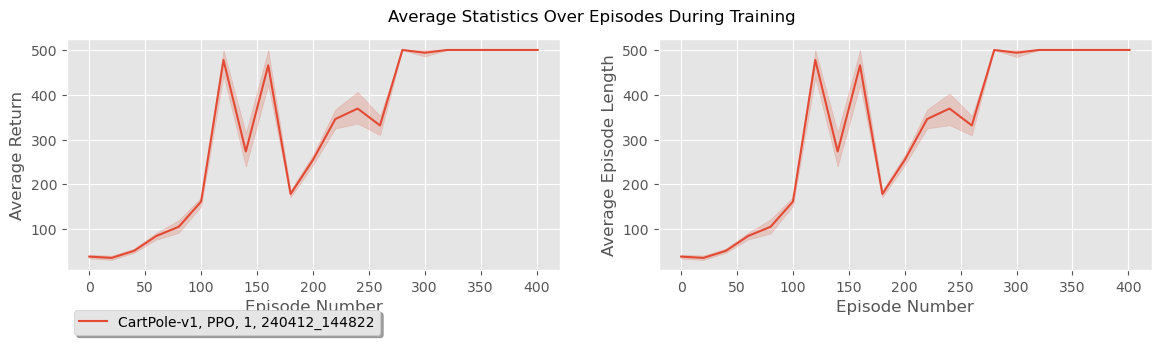

In [8]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = exp.run_name
eval_params.exp_type00 = exp.exp_type

# eval_params.run_name01 = "CartPole-v1__PPO__1__230302_224624"
# eval_params.exp_type01 = None

# eval_params.run_name02 = "CartPole-v1__PPO__1__230302_221245"
# eval_params.exp_type02 = None

agent_labels = []

episode_axis_limit = None

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

In [9]:
# %load_ext tensorboard
# %tensorboard --logdir logs --host localhost